In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
rest_available = [ 2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [5]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [6]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [7]:
num_seg = len(rest_available)+1

In [8]:
num_seg

46

In [9]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im)
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [10]:
file_names = pd.read_csv("all_complete_path.csv")

In [11]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [12]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [13]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:4986]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [14]:
cd = True
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 10
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [15]:
data = next(iter(dataloader['train']))

In [16]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [17]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [18]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [19]:
model = torch.load('new_loss_fn_4_46_5_dice')

In [20]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).cpu().numpy()

In [30]:
colors = ['viridis','plasma','summer','Oranges','spring','Wistia','winter','coolwarm_r','spring_r',\
          'Wistia_r','coolwarm','summer_r','viridis','plasma','summer','Oranges','spring','Wistia','winter','coolwarm_r','spring_r',\
          'Wistia_r','coolwarm','viridis','plasma','summer','Oranges','spring','Wistia','winter','coolwarm_r','spring_r',\
          'Wistia_r','coolwarm','viridis','plasma','summer','Oranges','spring','Wistia','winter','coolwarm_r','spring_r',\
          'Wistia_r','coolwarm']

In [28]:
def visualize_tissue(list_segs):
    print("\t \t Original MRI \t \t \t \t Ground Truth \t \t \t \t Predictions")
    inputs = next(iter(dataloader['validate']))
    model.train(False)
    x = inputs['x']
    x = Variable(x).cuda()
    output = model(x)
    
    for j in range(bs):
        imgs_masked = [0]*45
        out_masked = [0]*45
        inp_img = inputs['y'][j,:,:,:].numpy()
        out_img = visualize1(output[j,:,:,:])
        if np.sum(inp_img[-1,:,:] == 256*256):
            continue
        if np.isnan(np.sum(inputs['x'][j,0,:,:].numpy())):
            continue
        #compute accuracy
        
        max_inp_img = (torch.max(inputs['y'][j,:,:,:],dim = 0)[1]).numpy()
        max_pred_img = (torch.max(torch.from_numpy(out_img),dim = 0)[1]).numpy()
        masked_max_inp = np.ma.masked_where(max_inp_img == len(rest_available),max_inp_img)
        masked_max_pred_inp = np.ma.masked_where(max_inp_img == len(rest_available),max_pred_img)
        total_acc = np.mean(masked_max_inp == masked_max_pred_inp)
        print('Accuracy =',total_acc)
        
        
        for i in list_segs:
            imgs_masked[i] = np.ma.masked_where(inp_img[i,:,:] == 0, inp_img[i,:,:])
            out_masked[i] = np.ma.masked_where(out_img[i,:,:] == 0, out_img[i,:,:])
    
    
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        
        plt.subplot(1,3,2)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        

        for i in list_segs:
            if np.sum(imgs_masked[i]) != 0:
                plt.imshow(imgs_masked[i], colors[i], interpolation='none', alpha=0.9)
                
        plt.subplot(1,3,3)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')
        
        for i in list_segs:
            if np.sum(out_masked[i]) !=0:
                plt.imshow(out_masked[i], colors[i], interpolation='none', alpha=0.9)
        
        plt.show()
        print('-'*100)

	 	 Original MRI 	 	 	 	 Ground Truth 	 	 	 	 Predictions
Accuracy = 0.8606965174129353


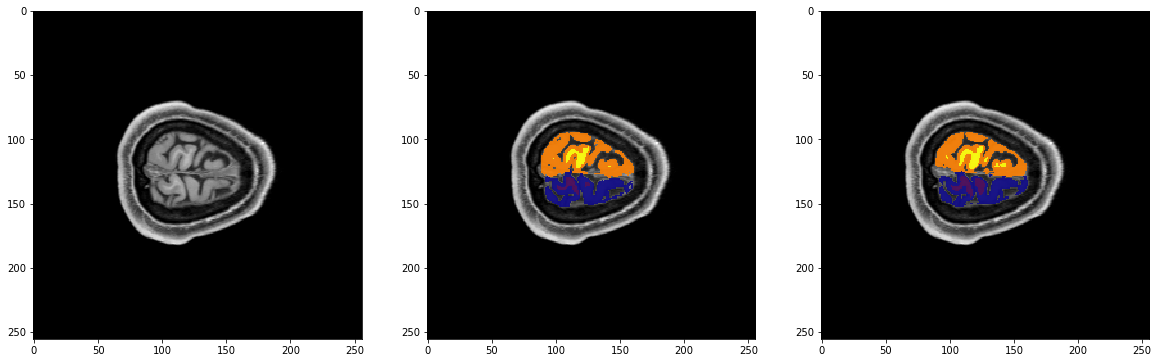

----------------------------------------------------------------------------------------------------
Accuracy = 0.9339265850945495


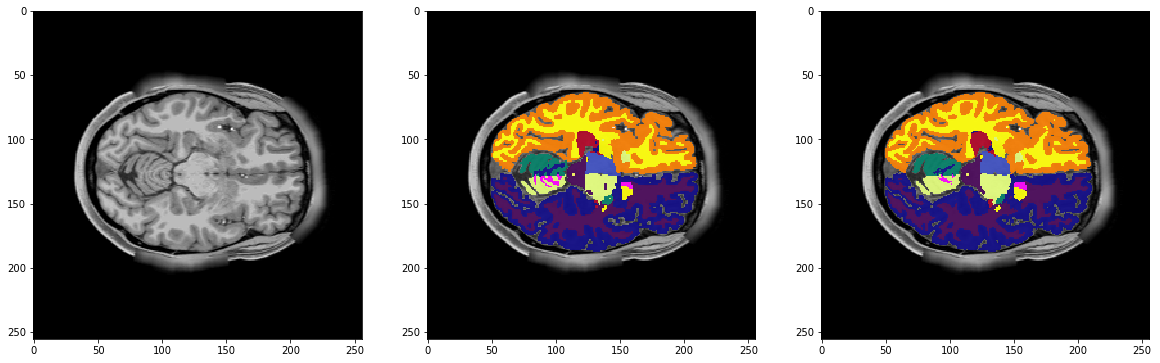

----------------------------------------------------------------------------------------------------
Accuracy = 0.946524064171123


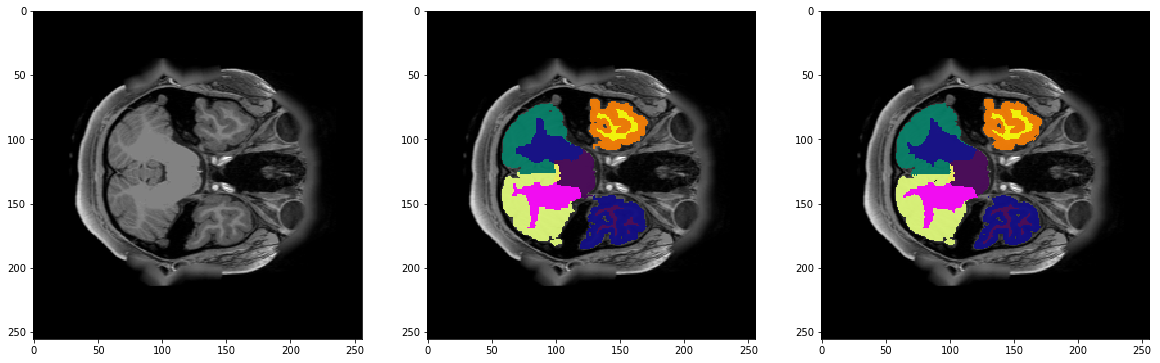

----------------------------------------------------------------------------------------------------
Accuracy = 0.9120038259206121


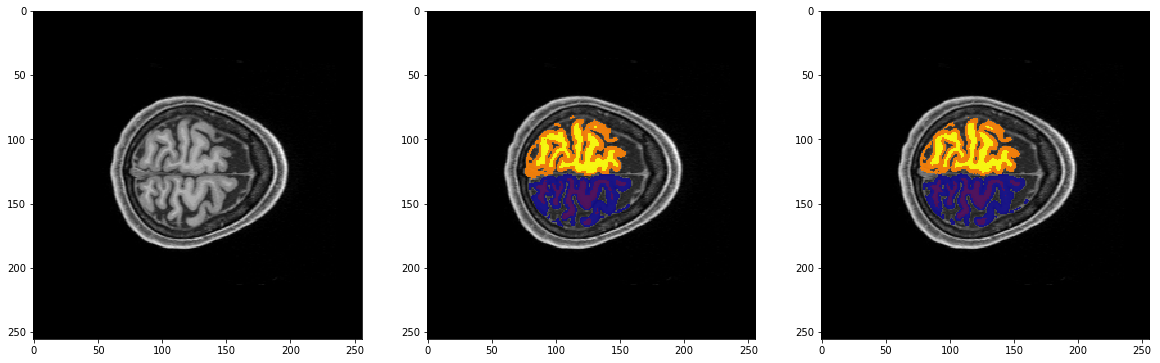

----------------------------------------------------------------------------------------------------
Accuracy = 0.6437308868501529


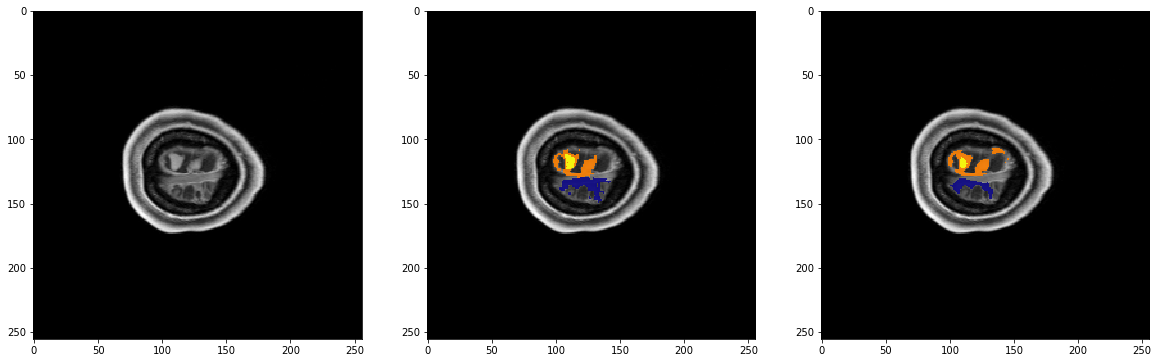

----------------------------------------------------------------------------------------------------
Accuracy = 0.52


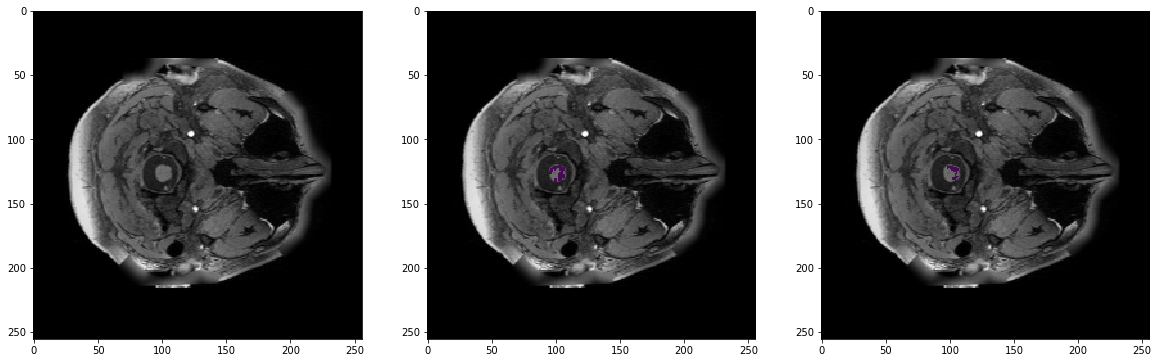

----------------------------------------------------------------------------------------------------


In [36]:
visualize_tissue(np.arange(45))

	 	 Original MRI 	 	 	 	 Ground Truth 	 	 	 	 Predictions
Accuracy = 0.9536908928135428


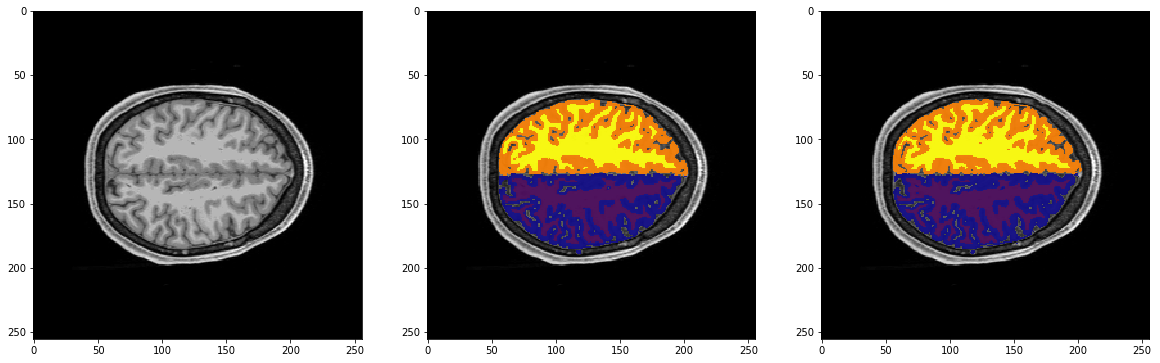

----------------------------------------------------------------------------------------------------
Accuracy = 0.967741935483871


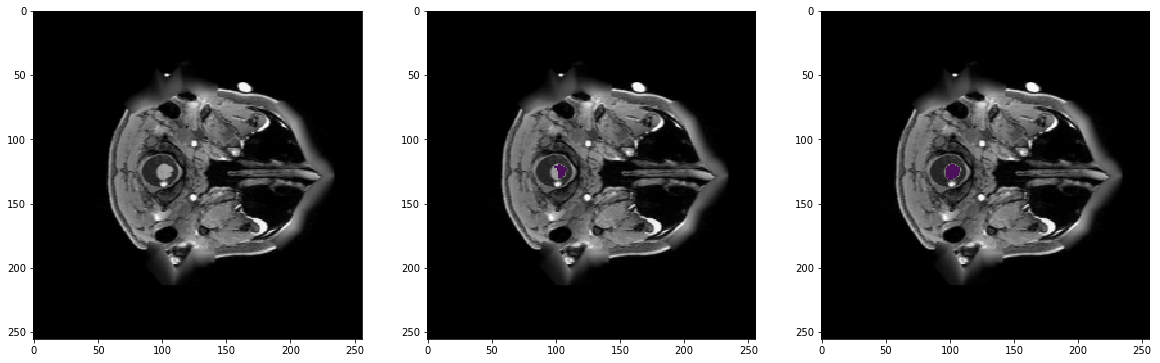

----------------------------------------------------------------------------------------------------
Accuracy = 0.9554556832404142


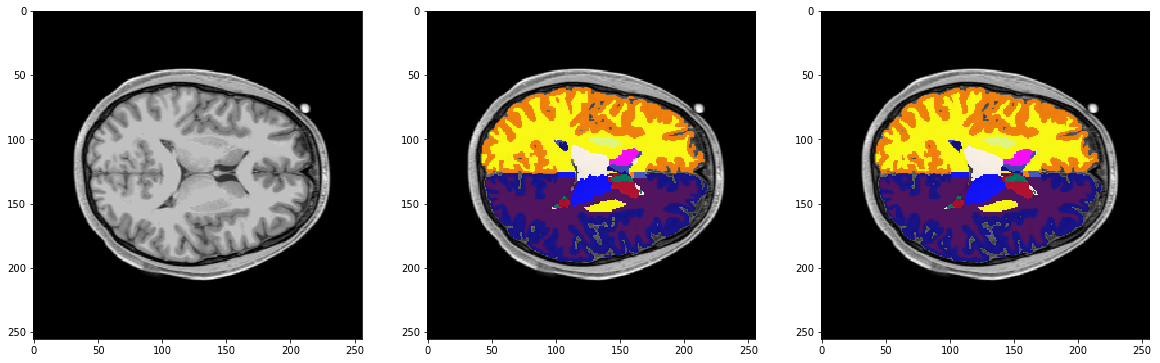

----------------------------------------------------------------------------------------------------
Accuracy = 0.9200030857054694


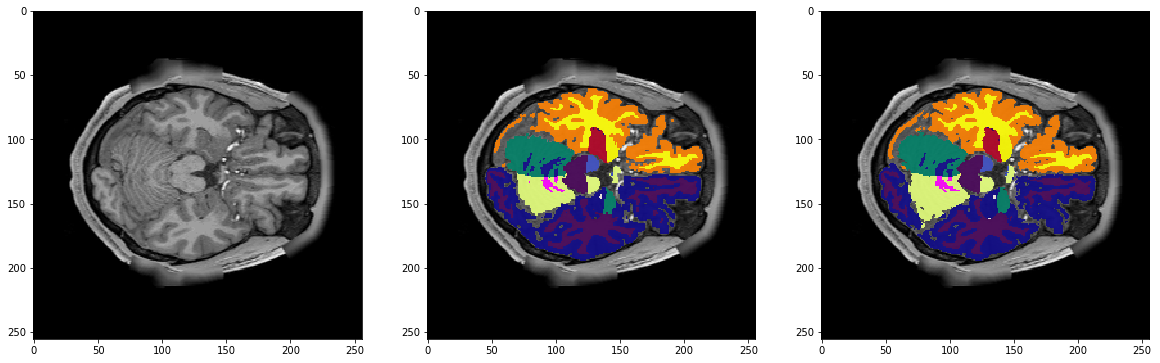

----------------------------------------------------------------------------------------------------
Accuracy = --


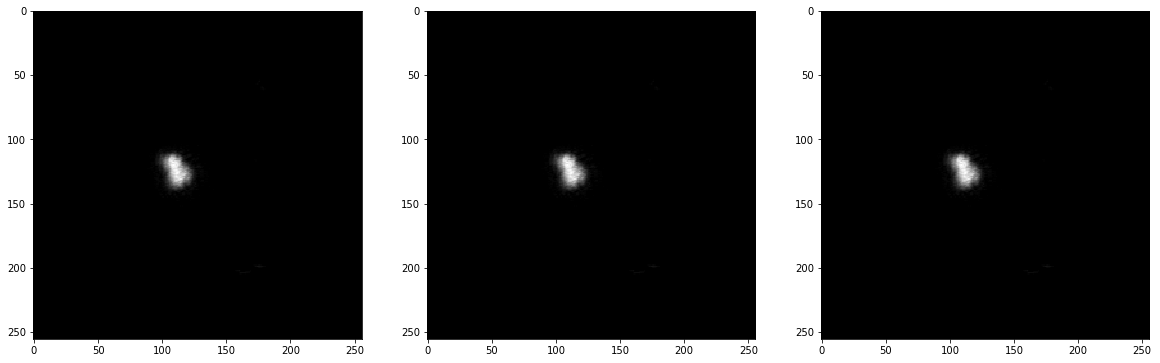

----------------------------------------------------------------------------------------------------


In [37]:
visualize_tissue(np.arange(45))

	 	 Original MRI 	 	 	 	 Ground Truth 	 	 	 	 Predictions
Accuracy = 0.9318604520092431


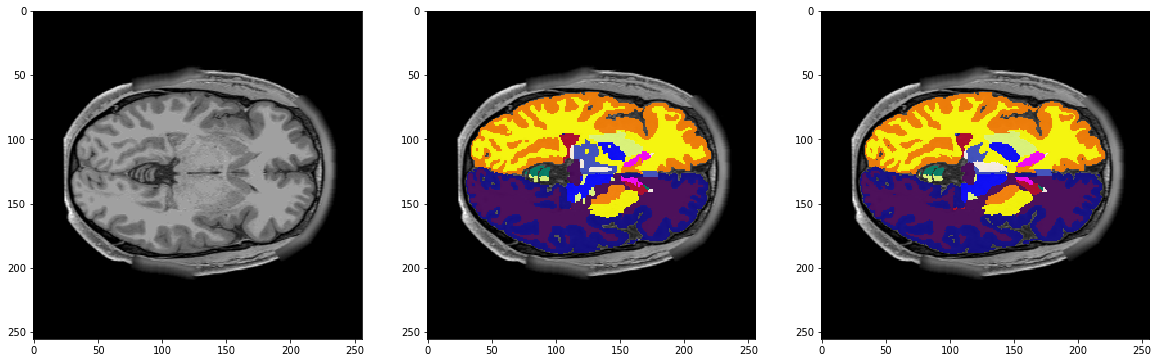

----------------------------------------------------------------------------------------------------
Accuracy = --


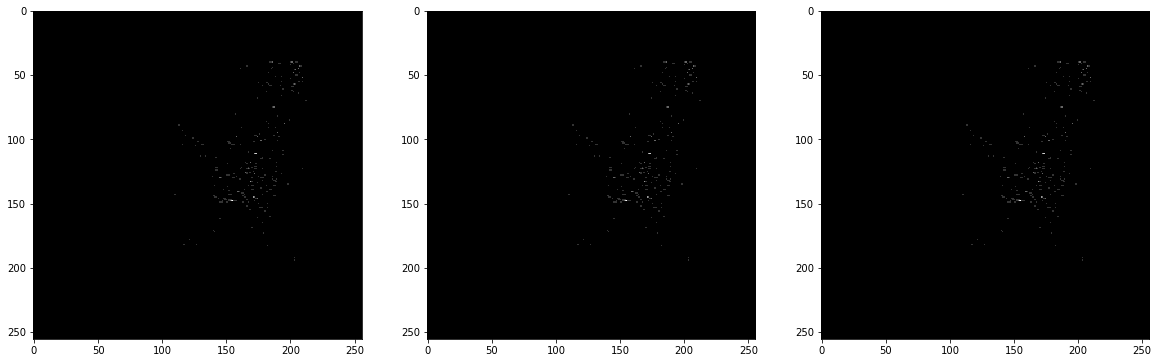

----------------------------------------------------------------------------------------------------
Accuracy = 0.9382936065938962


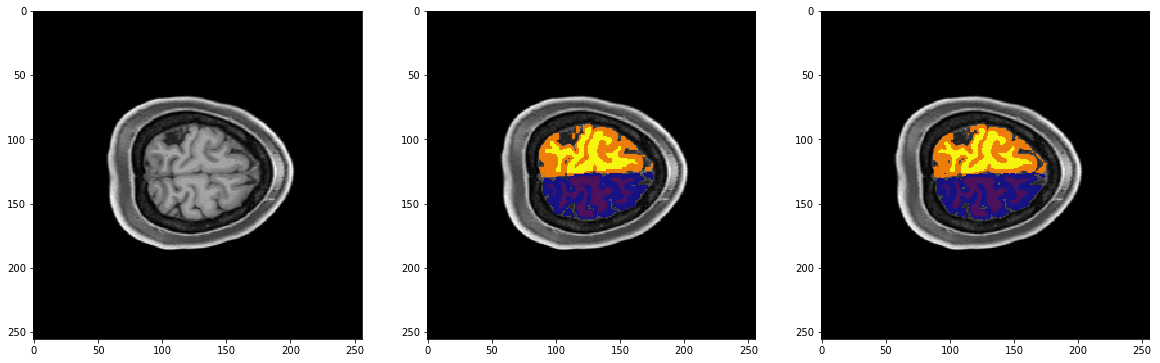

----------------------------------------------------------------------------------------------------
Accuracy = --


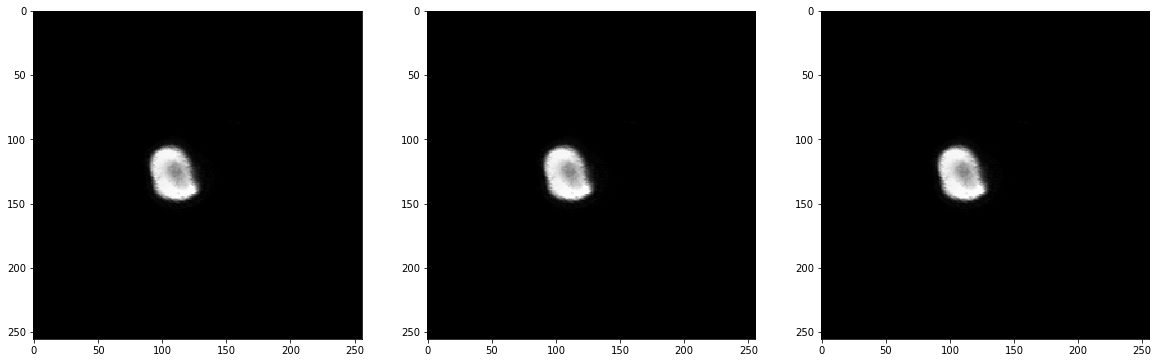

----------------------------------------------------------------------------------------------------
Accuracy = 0.9572815533980582


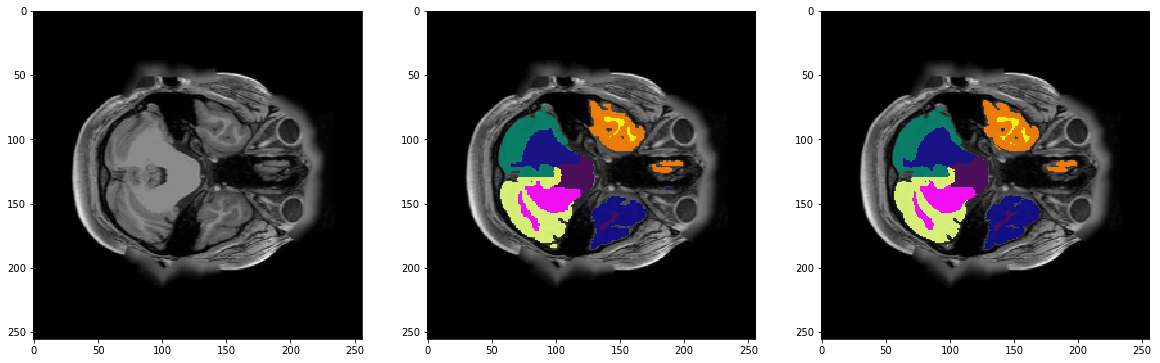

----------------------------------------------------------------------------------------------------


In [38]:
visualize_tissue(np.arange(45))

	 	 Original MRI 	 	 	 	 Ground Truth 	 	 	 	 Predictions
Accuracy = 0.7884231536926147


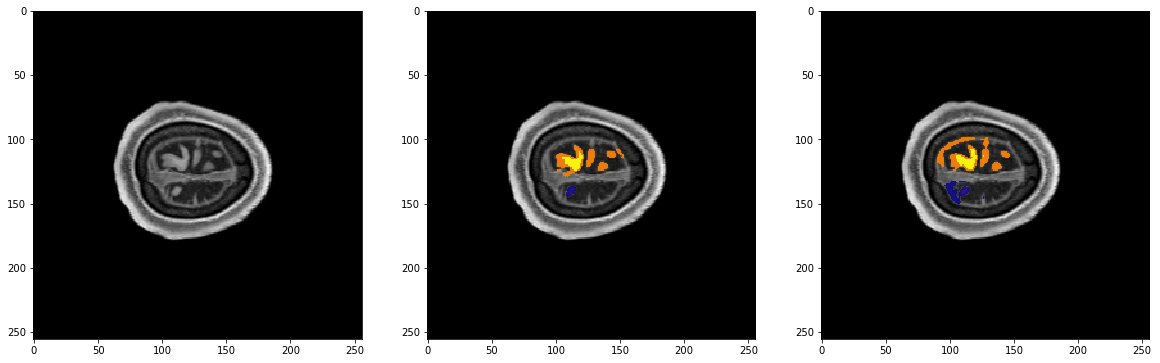

----------------------------------------------------------------------------------------------------
Accuracy = 0.9489033502048686


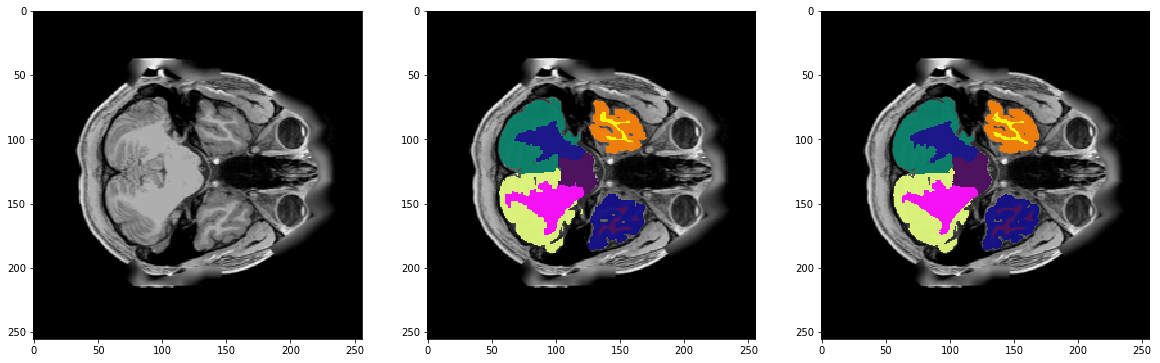

----------------------------------------------------------------------------------------------------
Accuracy = 0.9234485720420872


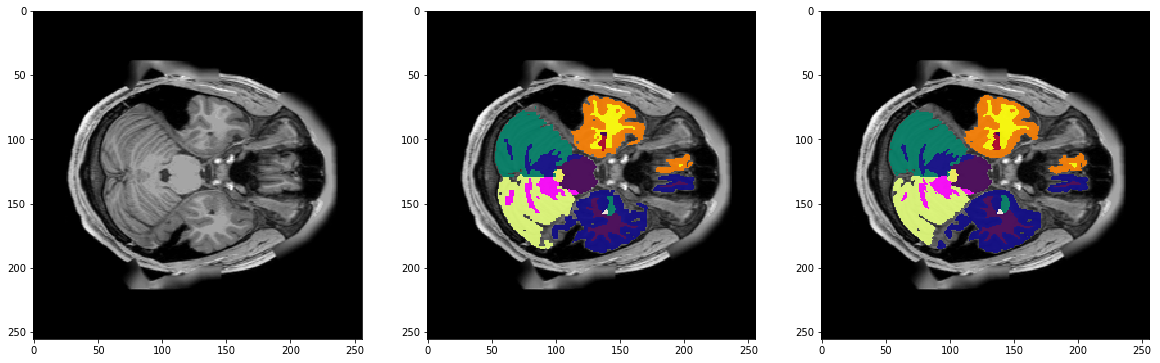

----------------------------------------------------------------------------------------------------
Accuracy = 0.9407697485161843


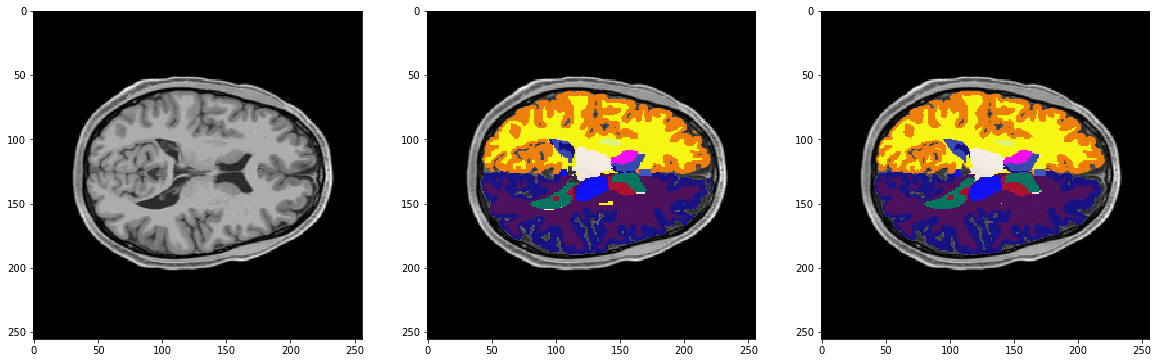

----------------------------------------------------------------------------------------------------
Accuracy = 0.9564959070504357


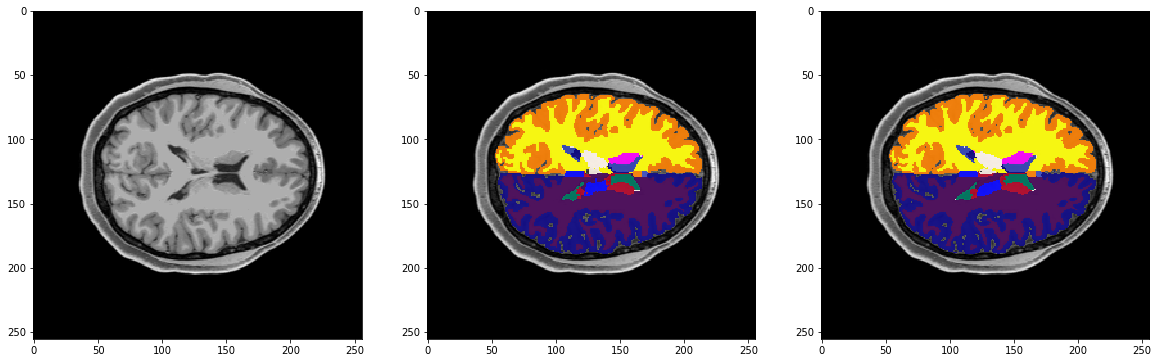

----------------------------------------------------------------------------------------------------
Accuracy = 0.962865090403338


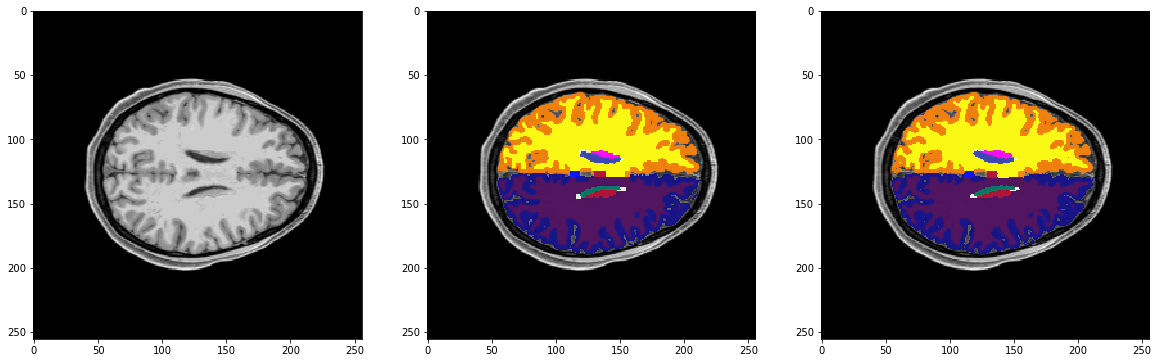

----------------------------------------------------------------------------------------------------
Accuracy = 0.954301561463797


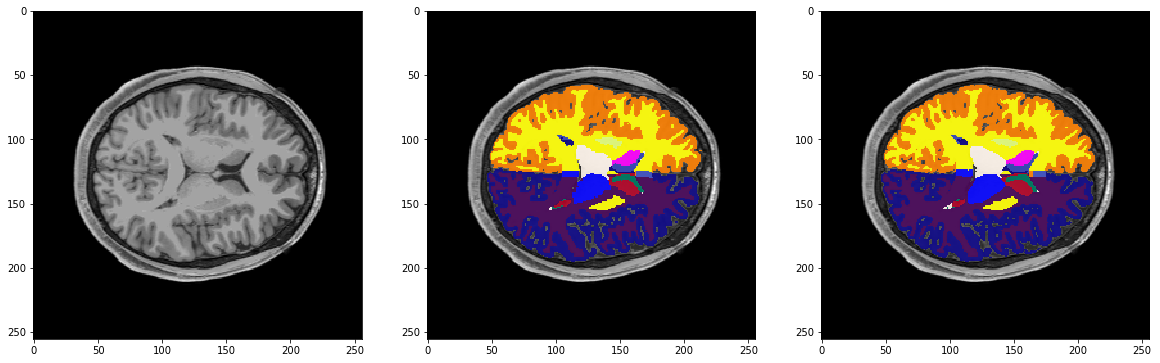

----------------------------------------------------------------------------------------------------
Accuracy = 0.9596512224311848


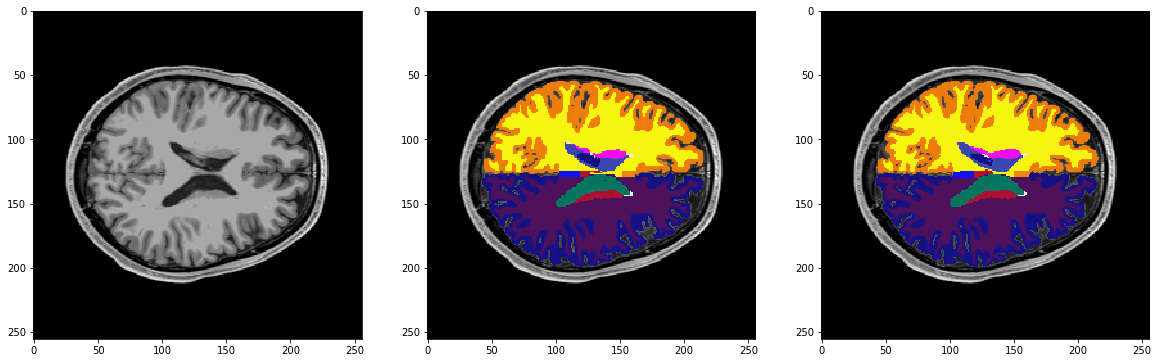

----------------------------------------------------------------------------------------------------


In [39]:
visualize_tissue(np.arange(45))